In [35]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad



In [ ]:
#This is the Pantheon+SH0ES data, cepheid variable calibrated Super Nova data
#We are going to use the MU_SH0ES,(distance modulus), zHD,(redshift) and MU_Sh0ES_error_diag,(error).

data = pd.read_csv("Pantheon+SH0ES_data.dat", delim_whitespace=True)

#replace infinities with Not a number
data = data.replace([np.inf, -np.inf], np.nan)

#remove the rows with missing values, zHD, redshift Hubble Diagram, MU_SH0ES, distance modulus and MU_SH0ES_ERR_DIAG, error in distance modulus.
data = data.dropna(subset=["zHD", "MU_SH0ES", "MU_SH0ES_ERR_DIAG"])

# Check: This prints how many missing values remain in these columns (should all be 0)
print(data[["zHD", "MU_SH0ES", "MU_SH0ES_ERR_DIAG"]].isna().sum())

# Print shape (rows, columns) so we see how many supernovae are left
print(data.shape)





zHD                  0
MU_SH0ES             0
MU_SH0ES_ERR_DIAG    0
dtype: int64
(1701, 47)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_9764\634117682.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv("Pantheon+SH0ES_data.dat", delim_whitespace=True)


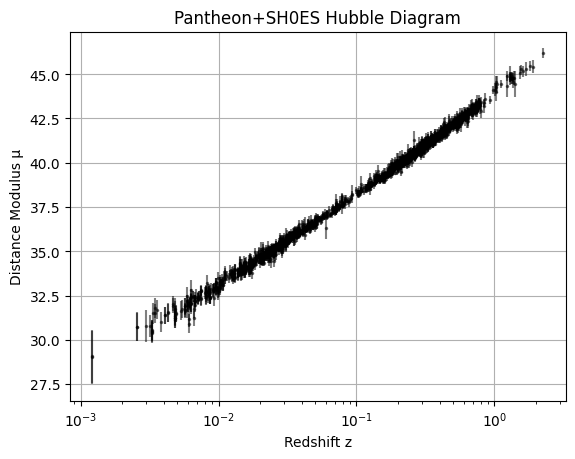

In [ ]:
# mu is the difference between apparent magnitude, m, and absolute magnitude, M.
#let d_l is luminosity distance. Then,
# mu = m - M = 5 log(d_l / 10 parsec)
# d_l = 10**(mu/5) * 10 parsecs
# or in MPc, we have d_l = 10 **((mu - 25)/5)

z = data["zHD"]                    # redshift Hubble Diagram
mu = data["MU_SH0ES"]              # distance modulus
mu_err = data["MU_SH0ES_ERR_DIAG"] # uncertainty in distance modulus

# Create an error-bar plot
plt.errorbar(z, mu, yerr=mu_err, fmt=".", markersize=3, color='black',alpha = 0.5)

# Make the x-axis logarithmic (helps visualize low & high z together)
plt.xscale("log")

# Label axes
plt.xlabel("Redshift z")
plt.ylabel("Distance Modulus μ")

# Title
plt.title("Pantheon+SH0ES Hubble Diagram")

# Show the plot
plt.grid()
plt.show()


Fitting on 741 SNe with 0 < z <= 0.1
Best-fit H0 = 73.01 ± 0.28 km/s/Mpc


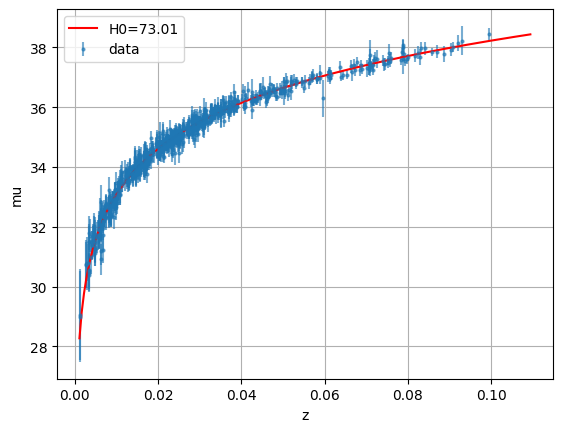

In [ ]:


#prepare data as numpy arrays
z_all = data["zHD"].values
mu_all = data["MU_SH0ES"].values
mu_err_all = data["MU_SH0ES_ERR_DIAG"].values

# replace infinities with not a number and then drop (safety)
# np. where acts like this: if finite, keep the value, otherwise replace with NaN

z_all = np.where(np.isfinite(z_all), z_all, np.nan)
mu_all = np.where(np.isfinite(mu_all), mu_all, np.nan)
mu_err_all = np.where(np.isfinite(mu_err_all), mu_err_all, np.nan)

#We create a mask so that:
#we now have clean, safe, finite-only data arrays for redshift, distance modulus, and uncertainties.

mask = ~np.isnan(z_all) & ~np.isnan(mu_all) & ~np.isnan(mu_err_all)
z_all = z_all[mask]; mu_all = mu_all[mask]; mu_err_all = mu_err_all[mask]

# we now restrict ourselves to low-z to make the d_L ≈ (c/H0) * z regime valid

# we can vary this value; low-z reduces systematics
zmax = 0.10          

#Drop values smaller than 0.0001 and greater than z_max

mask_lowz = z_all > 1e-4  
mask_lowz &= z_all <= zmax

z = z_all[mask_lowz]
mu_obs = mu_all[mask_lowz]
mu_err = mu_err_all[mask_lowz]

print(f"Fitting on {len(z)} SNe with 0 < z <= {zmax}")

# I assume a flat Lambda CDM model with matter density 0.3 and dark energy density 0.7
c= 299792.458 

Omega_m = 0.3
Omega_L = 0.7

#Now, we write down the expression for luminosity distance as a function of redshift

def E_inv(zp, Om, OL):
    return 1.0 / np.sqrt(Om * (1 + zp)**3 + OL)

#luminosity distance for a single point.
def dL_single(zp, H0, Om=Omega_m, OL=Omega_L):
    
    integral, _ = quad(E_inv, 0.0, zp, args=(Om, OL), epsabs=1e-6, epsrel=1e-6)
    return (c / H0) * (1 + zp) * integral  # Mpc

# luminosity distance for all points
def dL_vec(zarr, H0, Om=Omega_m, OL=Omega_L):
    
    return np.array([dL_single(zi, H0, Om, OL) for zi in np.atleast_1d(zarr)])

#Now, we use definition of distance modulus, mu.
# mu = 5 log (d_l/10 parsec) = 5 log(d_l/MPc) + 25


def mu_theory(zarr, H0, Om=Omega_m, OL=Omega_L):
    dl = dL_vec(zarr, H0, Om, OL)
    
    # safety: ensure dl positive
    if np.any(dl <= 0) or np.any(~np.isfinite(dl)):
        return np.full_like(np.atleast_1d(zarr), 1e6)  # force large mismatch if bad
    
    return 5.0 * np.log10(dl) + 25.0

# curve_fit with bounds and initial guess 
p0 = [70.0]                  # initial guess for H0
bounds = ([50.0], [90.0])   # physically sensible bounds

popt, pcov = curve_fit(mu_theory,z, mu_obs, sigma=mu_err, p0=p0, bounds=bounds, absolute_sigma=True, maxfev=10000)

H0_fit = popt[0]
H0_err = np.sqrt(np.diag(pcov))[0]

print(f"Best-fit H0 = {H0_fit:.2f} ± {H0_err:.2f} km/s/Mpc")

# --- quick plot ---
z_plot = np.linspace(min(z)*0.9, max(z)*1.1, 200)

plt.errorbar(z, mu_obs, yerr=mu_err, fmt='.', ms=4, alpha=0.6, label='data')
plt.plot(z_plot, mu_theory(z_plot, H0_fit), 'r-', label=f'H0={H0_fit:.2f}')
plt.xlabel('z')
plt.ylabel('mu')
plt.legend()
plt.xscale('linear')
plt.grid()
plt.show()
